# Import modules

In [40]:
import qiskit
import pylatexenc
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf

In [41]:
import gym
from functools import reduce
from collections import deque, defaultdict

In [42]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import math, random, time, itertools
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter, ParameterVector
from tqdm.notebook import tqdm
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, CircuitOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian

# Build CIrucit

In [43]:
def add_single_qubit_rotation(circuit, Paramvector, n_qubits):
    for i in range(n_qubits):
        circuit.rx(Paramvector[i], i)
        circuit.ry(Paramvector[i], i)
        circuit.rz(Paramvector[i], i)
def add_encoding_layer(circuit, Paramvector, n_qubits):
    for i in range(n_qubits):
        circuit.rx(Paramvector[i], i)
def add_entangling_layer(circuit, n_qubits):
    qubits = [i for i in range(n_qubits)]
    for c in itertools.combinations(qubits, 2):
        circuit.cz(c[0], c[1])

In [44]:
def build_circuit(n_qubits, n_layers):
    qr = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qr)
    
    param_rot = ParameterVector('Rot', 3*n_qubits*(n_layers+1))
    param_enc = ParameterVector('Enc', n_qubits*n_layers)
    
    for l in range(n_layers):
        # Variational + Encoding Layer
        add_single_qubit_rotation(qc, param_rot[l*(3*n_qubits):(l+1)*(3*n_qubits)], n_qubits)
        qc.barrier()
        add_entangling_layer(qc, n_qubits)
        qc.barrier()
        # Encoding Layer
        add_encoding_layer(qc, param_enc[l*n_qubits:(l+1)*n_qubits], n_qubits)
        qc.barrier()
    # Last Variational Layer
    add_single_qubit_rotation(qc, param_rot[n_layers*(3*n_qubits):(n_layers+1)*(3*n_qubits)], n_qubits)
    
    return qc, param_rot, param_enc

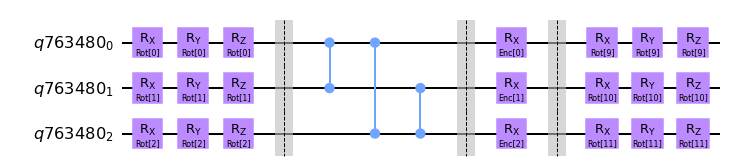

In [45]:
def draw_example():
    quantum_circuit, param_rot, param_enc = build_circuit(n_qubits=3, n_layers=1)
    return quantum_circuit
draw_example().draw('mpl')

In [46]:
class PQC_with_DataReuploading(nn.Module):
    def __init__(self, n_qubits, n_layers, output_dim, observables=None, activation='linear'):
        super().__init__()
        
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.activation = activation
        
        if observables == None:
            self.observables = Z^n_qubits
        else:
            self.observables = observables
        
        # Build circuits / Parameter Vectors
        self.circuit, self.rot_params, self.enc_params = build_circuit(self.n_qubits, self.n_layers)
        self.len_rot_params = len(self.rot_params)
        self.len_enc_params = len(self.enc_params)
        
        self.total_params = []
        for p in self.rot_params:
            self.total_params.append(p)
        for p in self.enc_params:
            self.total_params.append(p)
        
        # Initial Parameters for circuit
        self.rot_param_vals = nn.Parameter(np.pi * torch.rand(len(self.rot_params)))
        self.enc_param_vals = nn.Parameter(torch.ones(len(self.enc_params)))
        
        # Parameter for circuit output
        self.w = nn.Parameter(nn.Parameter(torch.rand(self.output_dim)))
        
    def forward(self, inputs):
        # Input: State values -> Need to insert into Encoding gates with scaling parameters(encoding params)
        input_tiled = inputs.tile(self.n_layers)
#         print(input_tiled)
        input_scaled = self.enc_param_vals * input_tiled
        input_params = input_scaled
    
        
        # Make state fucntion & Get expectation value of observable
        circ_psi = CircuitStateFn(primitive=self.circuit, coeff=1.)
        expectation = ~ circ_psi @ self.observables @ circ_psi
        
        # Assignn Parameter values
        value_dict = {}
        for i, p in enumerate(self.rot_params):
            value_dict[p] = self.rot_param_vals[i].item()
        for i, p in enumerate(self.enc_params):
            value_dict[p] = input_params[i].detach().item()
            
        # Final expectation value
        expectation_val = expectation.assign_parameters(value_dict).eval().real
        action_exp = torch.tensor(expectation_val) * self.w
        action_prob = F.softmax(action_exp, dim=0)
        
        return action_prob
    
    def get_grad(self, inputs):
        input_tiled = inputs.tile(self.n_layers)
        input_scaled = self.enc_param_vals * input_tiled
        input_params = input_scaled
        
        value_dict = {}
        for i, p in enumerate(self.rot_params):
            value_dict[p] = self.rot_param_vals[i].item()
        for i, p in enumerate(self.enc_params):
            value_dict[p] = input_params[i].detach().item()
        
        psi = CircuitStateFn(primitive=self.circuit, coeff=1.)
        op = ~StateFn(self.observables) @ psi
        grad = Gradient(grad_method='param_shift').convert(operator=op, params=self.total_params)
#         grad = Gradient(grad_method='fin_diff').convert(operator=op, params=self.total_params)
        grad_val = grad.assign_parameters(value_dict).eval()
        rot_grad = torch.tensor([grad_val[i].real for i in range(self.len_rot_params)])
        enc_grad = torch.tensor([grad_val[self.len_rot_params + i].real for i in range(self.len_enc_params)])
        
        expectation = ~ psi @ self.observables @ psi
        expectation_val = expectation.assign_parameters(value_dict).eval().real
        w_grad = torch.tensor([float(expectation_val)*self.w[i] for i in range(len(self.w))])
        return rot_grad, enc_grad, w_grad
    
    def get_grad2(self, inputs):
        input_tiled = inputs.tile(self.n_layers)
        input_scaled = self.enc_param_vals * input_tiled
        input_params = input_scaled
            
        circ_psi = CircuitStateFn(primitive=self.circuit, coeff=1.)
        expectation = ~ circ_psi @ self.observables @ circ_psi
                
        value_dict = {}
        for i, p in enumerate(self.rot_params):
            value_dict[p] = self.rot_param_vals[i].item()
        for i, p in enumerate(self.enc_params):
            value_dict[p] = input_params[i].detach().item()
        
        rot_grad = []
        for idx in range(self.len_rot_params):

            value_dict[self.rot_params[idx]] += np.pi/2
            expectation_plus = expectation.assign_parameters(value_dict).eval().real
            value_dict[self.rot_params[idx]] -= np.pi
            expectation_minus = expectation.assign_parameters(value_dict).eval().real
            rot_grad.append(0.5*(expectation_plus - expectation_minus))
        
        value_dict[self.rot_params[idx]] += np.pi/2
        
        enc_grad = []
        for idx in range(self.len_enc_params):
            value_dict = {}
            for i, p in enumerate(self.rot_params):
                value_dict[p] = self.rot_param_vals[i].item()
            for i, p in enumerate(self.enc_params):
                value_dict[p] = input_params[i].detach().item()

            value_dict[self.enc_params[idx]] += np.pi/2
            expectation_plus = expectation.assign_parameters(value_dict).eval().real
            value_dict[self.enc_params[idx]] -= np.pi
            expectation_minus = expectation.assign_parameters(value_dict).eval().real
            enc_grad.append(0.5*(expectation_plus - expectation_minus))
        
        value_dict[self.enc_params[idx]] += np.pi/2
        
        expectation = expectation.assign_parameters(value_dict).eval().real
        w_grad = torch.tensor([float(expectation)*self.w[i] for i in range(len(self.w))])
        
        return torch.tensor(rot_grad), torch.tensor(enc_grad), w_grad

In [47]:
policy = PQC_with_DataReuploading(n_qubits=4, n_layers=1, output_dim=2)

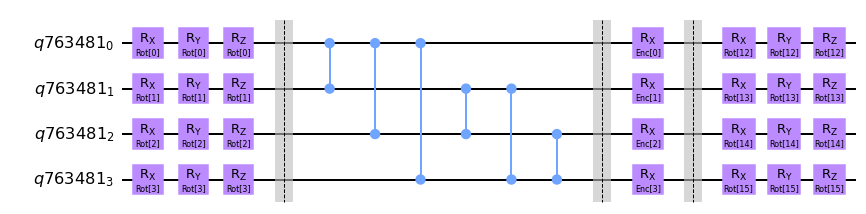

In [48]:
policy.circuit.draw('mpl')

In [49]:
inputs = torch.tensor([0.5,0.5,0.5,0.5])

In [50]:
policy.get_grad(inputs)

(tensor([ 0.0296,  0.1056, -0.0067, -0.0924,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.3111,  0.6113, -0.3261, -0.2840,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]),
 tensor([0.3381, 0.4605, 0.0837, 0.1572]),
 tensor([-0.0141, -0.0519]))

In [51]:
policy.get_grad2(inputs)

(tensor([-0.0387, -0.1109, -0.0436,  0.0232,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.1876, -0.3773,  0.2314, -0.0183,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        dtype=torch.float64),
 tensor([0.3381, 0.4605, 0.0837, 0.1572], dtype=torch.float64),
 tensor([-0.0141, -0.0519]))

# Make Quantum Agent

In [52]:
class QuantumAgent():
    def __init__(self, input_state_dim, n_actions, n_layers=1):
        self.policy = PQC_with_DataReuploading(n_qubits=input_state_dim, n_layers=n_layers, 
                                               output_dim=n_actions, observables=None,
                                               activation='linear')
        self.n_layers = n_layers
        self.variational_optim = torch.optim.Adam([self.policy.rot_param_vals], lr=0.01)
        self.encoding_optim = torch.optim.Adam([self.policy.enc_param_vals], lr=0.01)
        self.weight_optim = torch.optim.Adam([self.policy.w], lr=0.001)
        
        self.optims = [self.variational_optim, self.encoding_optim, self.weight_optim]
        
    def get_actions(self, input_state):
        return self.policy.forward(input_state)
    
    def update_policy(self, states, id_action_pairs, returns, action_probs, batch_size):
        rot_gradient, enc_gradient, w_gradient = [], [], []
        for s in states:
            r_grad, e_grad, w_grad = self.policy.get_grad(s)
            rot_gradient.append(np.array(r_grad))
            enc_gradient.append(np.array(e_grad))
            w_gradient.append(np.array(w_grad))
        
        rot_gradient = torch.from_numpy(np.array(rot_gradient))
        enc_gradient = torch.from_numpy(np.array(enc_gradient))
        w_gradient = torch.from_numpy(np.array(w_gradient))
        
        p_actions = torch.tensor([action_probs[id_action_pairs[i][0], id_action_pairs[i][1]] for i in range(action_probs.shape[0])])
        action_idxs = id_action_pairs[:,1]
        
        r_grad, e_grad, w_grad = torch.zeros(rot_gradient.shape[1]), torch.zeros(enc_gradient.shape[1]), torch.zeros(w_gradient.shape[1])
        for i in range(len(states)):
            r_grad += returns[i] * (rot_gradient[i]*self.policy.w[action_idxs[i]] 
                                    - torch.sum(p_actions[i]*self.policy.w)*rot_gradient[i])
   
            input_scaled = self.policy.enc_param_vals * states[i].tile(self.n_layers)
            e_grad +=  returns[i] * (enc_gradient[i]*self.policy.w[action_idxs[i]] 
                                     - input_scaled * torch.sum(p_actions[i]*self.policy.w)*enc_gradient[i])
            
            w_grad += returns[i] * (w_gradient[i]*self.policy.w[action_idxs[i]] 
                                    - torch.sum(p_actions[i]*self.policy.w)*w_gradient[i])
        
        for opt in self.optims:
            opt.zero_grad()
        
        self.policy.rot_param_vals.grad = r_grad / batch_size
        self.policy.enc_param_vals.grad = e_grad / batch_size
        self.policy.w.grad = w_grad / batch_size
                
        self.variational_optim.step()
        self.encoding_optim.step()
        self.weight_optim.step()
        
#     def update_policy(self, states, id_action_pairs, returns, action_probs, batch_size):
#         rot_gradient, enc_gradient, w_gradient = [], [], []
#         for s in states:
#             r_grad, e_grad, w_grad = self.policy.get_grad(s)
#             rot_gradient.append(np.array(r_grad))
#             enc_gradient.append(np.array(e_grad))
#             w_gradient.append(np.array(w_grad))
#         rot_gradient = torch.mean(torch.from_numpy(np.array(rot_gradient)), dim=0)
#         enc_gradient = torch.mean(torch.from_numpy(np.array(enc_gradient)), dim=0)
#         w_gradient = torch.mean(torch.from_numpy(np.array(w_gradient)), dim=0)
        
#         p_actions = torch.tensor([action_probs[id_action_pairs[i][0], id_action_pairs[i][1]] for i in range(action_probs.shape[0])])
#         log_probs = torch.log(p_actions)
#         loss = torch.sum(-log_probs * returns) / batch_size
        
#         for opt in self.optims:
#             opt.zero_grad()
        
#         self.policy.rot_param_vals.grad = loss * rot_gradient
#         self.policy.enc_param_vals.grad = loss * enc_gradient
#         self.policy.w.grad = loss * w_gradient
                
#         self.variational_optim.step()
#         self.encoding_optim.step()
#         self.weight_optim.step()

In [53]:
n_qubits = 4 # Dimension of the state vectors in CartPole
n_layers = 1
n_actions = 2 # Number of actions in CartPole
agent = QuantumAgent(input_state_dim = n_qubits, n_actions=n_actions, n_layers=n_layers)

# Run Episodes and Update Policy

In [54]:
def gather_episodes(state_bounds, n_actions, agent, n_episodes, env_name):
    """Interact with environment in batched fashion."""

    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    envs = [gym.make(env_name) for _ in range(n_episodes)]

    done = [False for _ in range(n_episodes)]
    states = [e.reset() for e in envs]

    while not all(done):
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]
        normalized_states = [s/state_bounds for i, s in enumerate(states) if not done[i]]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['states'].append(state)

        states = torch.from_numpy(np.array(normalized_states))
        action_probs = torch.from_numpy(np.array([agent.get_actions(states[i]).detach().numpy() for i in range(len(states))]))

        # Store action and transition all environments to the next state
        states = [None for i in range(n_episodes)]
        for i, action_prob in zip(unfinished_ids, action_probs.numpy()):
            action = np.random.choice(n_actions, p=action_prob)
            states[i], reward, done[i], _ = envs[i].step(action)
            trajectories[i]['actions'].append(action)
            trajectories[i]['rewards'].append(reward)
            trajectories[i]['action probs'].append(action_prob)

    return trajectories

def compute_returns(rewards_history, gamma):
    """Compute discounted returns with discount factor `gamma`."""
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

In [55]:
env_name = "CartPole-v1"
n_qubits = 4 # Dimension of the state vectors in CartPole
n_layers = 1
n_actions = 2 # Number of actions in CartPole
state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
gamma = 1
batch_size = 1
n_episodes = 200

In [ ]:
# Start training the agent
episode_reward_history = []
for batch in tqdm(range(n_episodes // batch_size)):
    # Gather episodes
    episodes = gather_episodes(state_bounds, n_actions, agent, batch_size, env_name)

    # Group states, actions and returns in numpy arrays
    states = torch.from_numpy(np.concatenate([ep['states'] for ep in episodes]))
    actions = torch.from_numpy(np.concatenate([ep['actions'] for ep in episodes]))
    action_probs = torch.from_numpy(np.concatenate([ep['action probs'] for ep in episodes]))
    rewards = [ep['rewards'] for ep in episodes]
    returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = torch.from_numpy(np.array(returns, dtype=np.float32))

    id_action_pairs = torch.from_numpy(np.array([[i, a] for i, a in enumerate(actions)]))

    # Update model parameters.
    agent.update_policy(states, id_action_pairs, returns, action_probs, batch_size)

    # Store collected rewards
    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-batch_size:])

    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards)

    if avg_rewards >= 500.0:
        break

  0%|          | 0/200 [00:00<?, ?it/s]

Finished episode 1 Average rewards:  20.0
Finished episode 2 Average rewards:  15.0
Finished episode 3 Average rewards:  13.0
Finished episode 4 Average rewards:  16.0
